![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

In [ ]:
# Some stuff to get us going:
!pip install invertedai
from IPython.display import clear_output
clear_output()

In [ ]:
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
import time
clear_output()

# Provide your API key

In [ ]:
iai.add_apikey("")

# Setup

Set up the simulation by defining the location, simulation length (1 step = 0.1 second), and some other constants.

In [ ]:
location = "iai:drake_street_and_pacific_blvd"
#location = "iai:marine_drive_viewpoint_3"

SIMULATION_LENGTH = 30
RENDERING_FOV = 130
FIGURE_SIZE = 10
AGENT_COUNT = 10
GIF_RATIO = 1.33
GIF_SIZE = 100*FIGURE_SIZE

# Preview the map location

(None, <matplotlib.image.AxesImage at 0x7e0a60a01e10>)

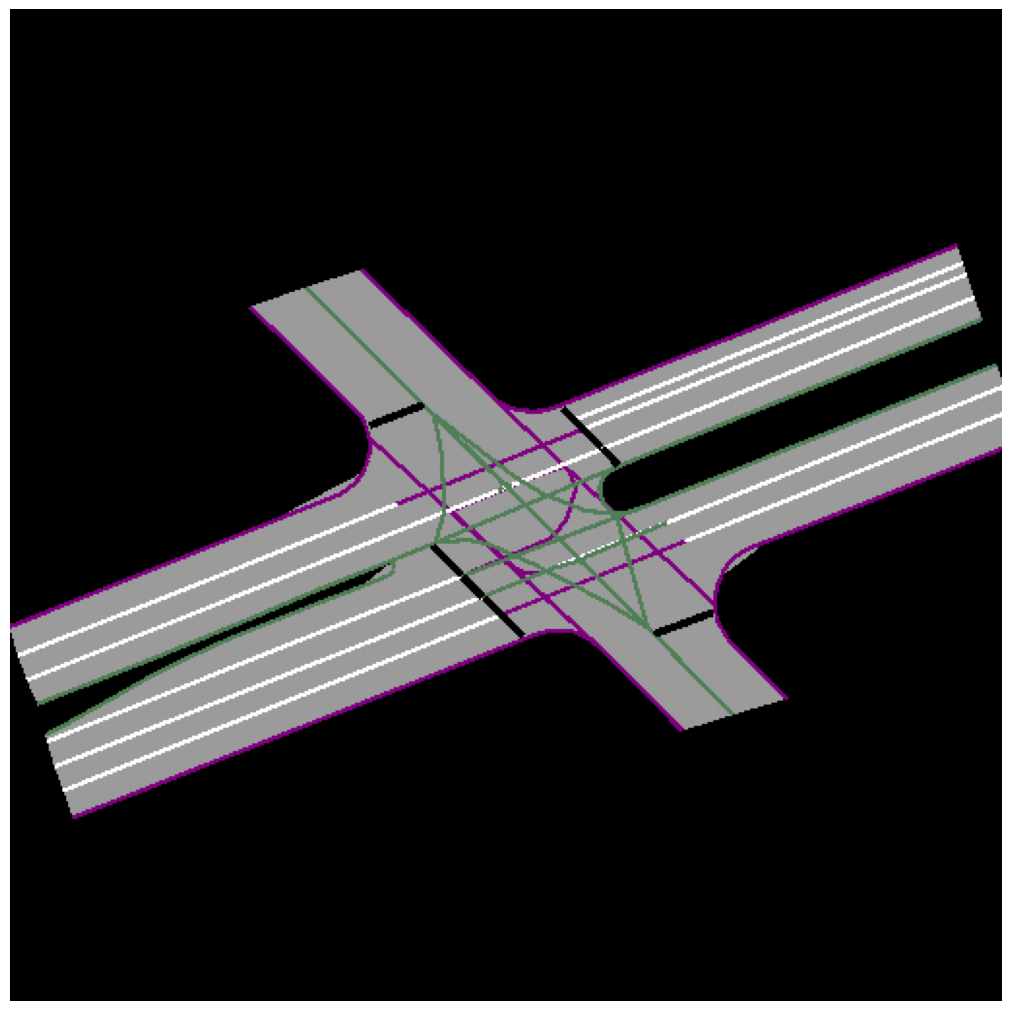

In [ ]:
location_info = iai.location_info(location=location,rendering_fov=RENDERING_FOV)
rendered_map = location_info.birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

In [ ]:
scene_plotter = iai.utils.ScenePlotter(rendered_map, RENDERING_FOV, (location_info.map_center.x, location_info.map_center.y), location_info.static_actors)

# Initialize the simulation

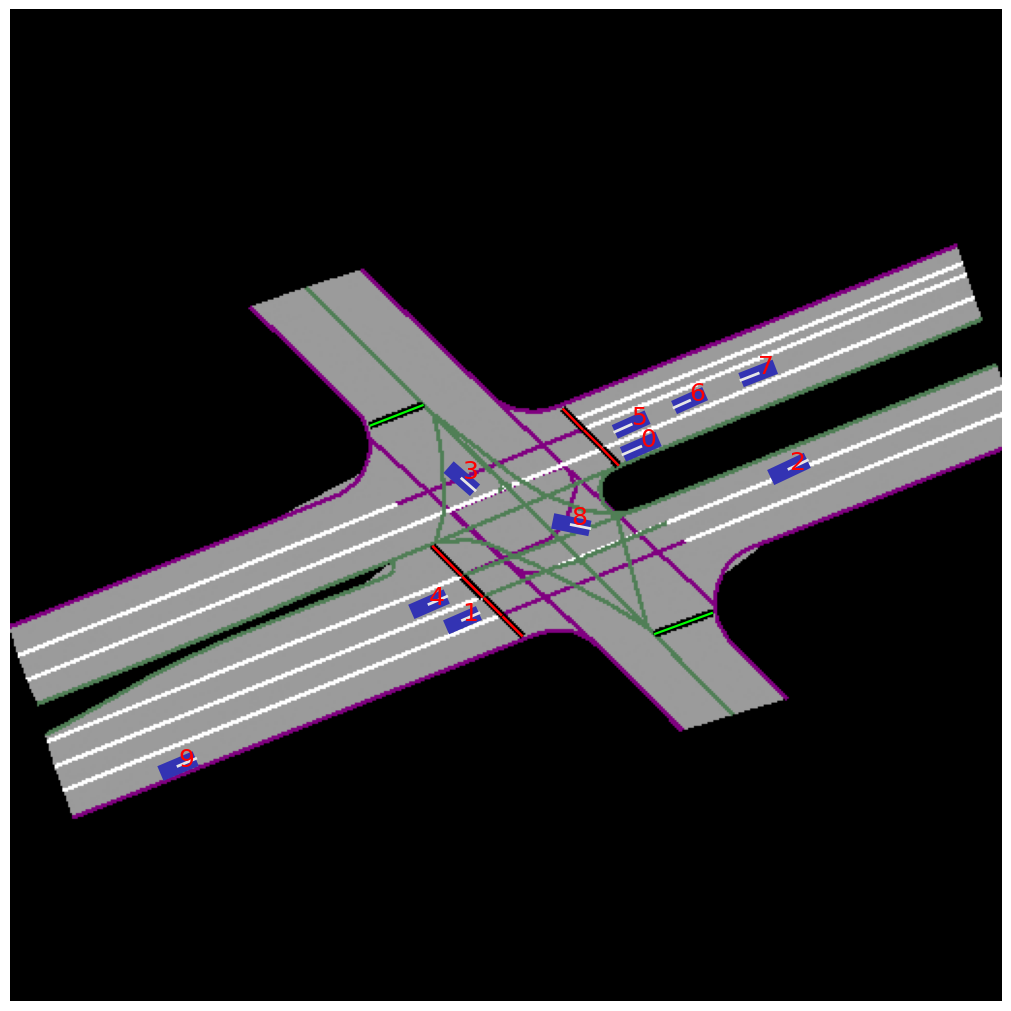

In [ ]:
simulation = iai.BasicCosimulation(
    location=location,
    ego_agent_mask=[False] * AGENT_COUNT,
    monitor_infractions = False,
    agent_count=AGENT_COUNT,
    get_birdview=False,
    random_seed=1,
    traffic_lights=any(actor.agent_type == "traffic-light" for actor in location_info.static_actors)
)
agent_attributes = simulation._agent_attributes

fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    simulation.agent_states,
    agent_attributes,
    traffic_light_states = simulation.light_states,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

# Start the simulation
\* Returning the birdviews will casue a much longer response time than running without them.

In [ ]:
scene_plotter.initialize_recording(simulation.agent_states, agent_attributes=agent_attributes, traffic_light_states=simulation.light_states)
times = []
for t in range(SIMULATION_LENGTH):
    t0 = time.time()
    simulation.step(current_ego_agent_states=[])

    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(simulation.agent_states, traffic_light_states=simulation.light_states);
    print(f'Iteration {t}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 1.14 over 30 calls


In [ ]:
%%capture
gif_name = 'basic-cosimulation-npc-only.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

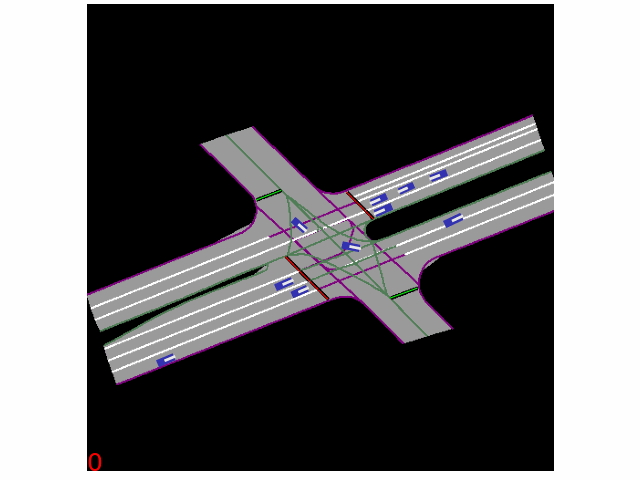

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)